In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-class/data.csv


In [3]:
import pandas as pd

df = pd.read_csv('/kaggle/input/data-class/data.csv')
df.head()

,unix_time,datetime,person,value,activity,sleep_duration,stress_lvl
0,1706086869,2024-01-24 10:01:09,Anh,171.1,Chill,8.0,0.457849
1,1706086870,2024-01-24 10:01:10,Anh,171.0,Chill,8.0,0.458344
2,1706086872,2024-01-24 10:01:12,Anh,170.9,Chill,8.0,0.458838
3,1706086873,2024-01-24 10:01:13,Anh,170.8,Chill,8.0,0.459333
4,1706086874,2024-01-24 10:01:14,Anh,170.7,Chill,8.0,0.459827


In [4]:
import time
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime'] = df['datetime'].dt.hour
df.head()

,unix_time,datetime,person,value,activity,sleep_duration,stress_lvl
0,1706086869,10,Anh,171.1,Chill,8.0,0.457849
1,1706086870,10,Anh,171.0,Chill,8.0,0.458344
2,1706086872,10,Anh,170.9,Chill,8.0,0.458838
3,1706086873,10,Anh,170.8,Chill,8.0,0.459333
4,1706086874,10,Anh,170.7,Chill,8.0,0.459827


In [5]:
df.dtypes

unix_time           int64
datetime            int32
person             object
value             float64
activity           object
sleep_duration    float64
stress_lvl        float64
dtype: object

In [6]:
df['stress_lvl'] = df['stress_lvl'].round(0)
df.head()

,unix_time,datetime,person,value,activity,sleep_duration,stress_lvl
0,1706086869,10,Anh,171.1,Chill,8.0,0.0
1,1706086870,10,Anh,171.0,Chill,8.0,0.0
2,1706086872,10,Anh,170.9,Chill,8.0,0.0
3,1706086873,10,Anh,170.8,Chill,8.0,0.0
4,1706086874,10,Anh,170.7,Chill,8.0,0.0


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.compose import ColumnTransformer

X = df.copy()
X.drop(columns=['stress_lvl', 'unix_time', 'person'], inplace=True)
y = df.stress_lvl

categorical_cols = ['activity']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_cols = ['datetime', 'value', 'sleep_duration']
numerical_transformer = make_pipeline(
    StandardScaler(),
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = to_categorical(y_train, num_classes=6)
y_valid = to_categorical(y_valid, num_classes=6)
input_shape = [X_train.shape[1]]

In [59]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=6, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[keras.metrics.CategoricalAccuracy()]
)

In [61]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)


Epoch 1/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - categorical_accuracy: 0.4224 - loss: 1.2914 - val_categorical_accuracy: 0.5338 - val_loss: 1.0481
Epoch 2/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.5491 - loss: 1.0179 - val_categorical_accuracy: 0.6058 - val_loss: 0.9254
Epoch 3/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.5964 - loss: 0.9276 - val_categorical_accuracy: 0.6242 - val_loss: 0.8746
Epoch 4/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.6112 - loss: 0.8886 - val_categorical_accuracy: 0.6270 - val_loss: 0.8516
Epoch 5/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - categorical_accuracy: 0.6219 - loss: 0.8635 - val_categorical_accuracy: 0.6428 - val_loss: 0.8260
Epoch 6/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.6313 - loss: 0.8486 - val_categorical_accuracy: 0.6565 - val_loss: 0.8079
Epoch 7/200
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_a

<Axes: title={'center': 'Training and Validation Accuracy'}>

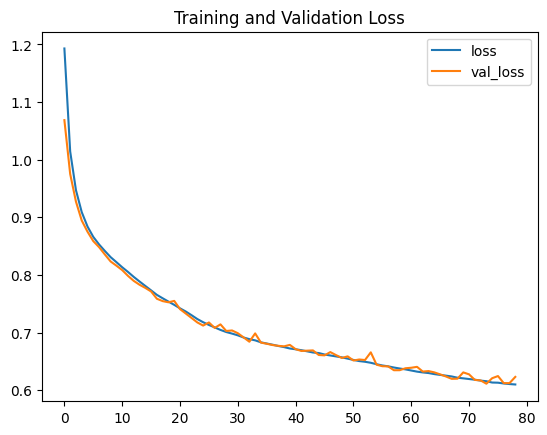

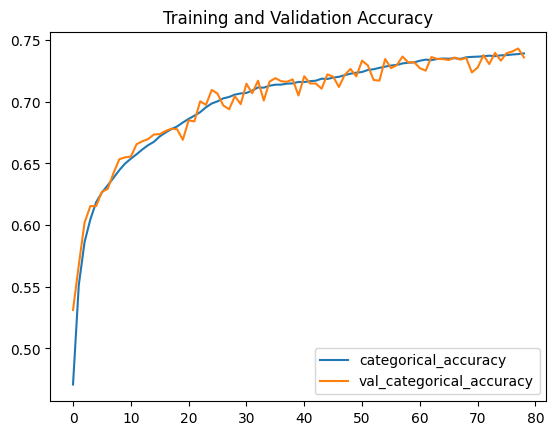

In [11]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Training and Validation Loss")
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot(title="Training and Validation Accuracy")

In [96]:
data = {
    "datetime": [15.0, 10.0, 17.0, 14.0, 19.0],
    "value": [80, 76.5, 81, 105, 85],
    "activity": ['Work', 'Chill', 'Hobby', 'Uni', 'Social'],
    "sleep_duration": [8.0, 8.0, 8.0, 8.0, 8.0]
}

test_df = pd.DataFrame(data)

test_df['datetime'] = test_df['datetime'].astype('float64')
test_df['sleep_duration'] = test_df['sleep_duration'].astype('float64')
test_df.dtypes

datetime          float64
value             float64
activity           object
sleep_duration    float64
dtype: object

In [97]:
categorical_cols = ['activity']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_cols = ['datetime', 'value', 'sleep_duration']
numerical_transformer = make_pipeline(
    StandardScaler(),
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

test_df_pre = preprocessor.fit_transform(test_df)

print(test_df_pre)

[[ 0.         -0.54351647  0.          0.          0.          0.
   0.          1.        ]
 [-1.64845118 -0.88939059  0.          1.          0.          0.
   0.          0.        ]
 [ 0.65938047 -0.4446953   0.          0.          1.          0.
   0.          0.        ]
 [-0.32969024  1.92701295  0.          0.          0.          0.
   1.          0.        ]
 [ 1.31876095 -0.04941059  0.          0.          0.          1.
   0.          0.        ]]


In [98]:
prediction = model.predict(test_df_pre)

prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([[2.29422410e-04, 3.24140713e-02, 9.64745939e-01, 2.61057331e-03,
        2.79307799e-10, 5.45039111e-13],
       [9.84192908e-01, 4.24315827e-03, 4.30193148e-04, 1.11336475e-02,
        2.75325380e-08, 0.00000000e+00],
       [9.60626245e-01, 4.85898599e-05, 2.78230961e-02, 5.91383396e-05,
        1.14430981e-02, 7.33927621e-13],
       [1.73378307e-02, 1.87677950e-01, 5.13467848e-01, 2.80918598e-01,
        5.97851700e-04, 0.00000000e+00],
       [5.02230192e-04, 9.91173565e-01, 7.72203552e-03, 6.02126122e-04,
        2.90376299e-11, 5.23802506e-15]], dtype=float32)

In [99]:
predicted_labels = prediction.argmax(axis=1)
print(predicted_labels)

[2 0 0 2 1]


In [100]:
for i, pred_probs in enumerate(prediction):
    print(f"Sample {i + 1} predicted probabilities:")
    for j, prob in enumerate(pred_probs):
        formatted_prob = "{:.2%}".format(prob)  # Format the probability as percentage with 2 decimal places
        print(f"Class {j}: {formatted_prob}")
    print()

Sample 1 predicted probabilities:
Class 0: 0.02%
Class 1: 3.24%
Class 2: 96.47%
Class 3: 0.26%
Class 4: 0.00%
Class 5: 0.00%

Sample 2 predicted probabilities:
Class 0: 98.42%
Class 1: 0.42%
Class 2: 0.04%
Class 3: 1.11%
Class 4: 0.00%
Class 5: 0.00%

Sample 3 predicted probabilities:
Class 0: 96.06%
Class 1: 0.00%
Class 2: 2.78%
Class 3: 0.01%
Class 4: 1.14%
Class 5: 0.00%

Sample 4 predicted probabilities:
Class 0: 1.73%
Class 1: 18.77%
Class 2: 51.35%
Class 3: 28.09%
Class 4: 0.06%
Class 5: 0.00%

Sample 5 predicted probabilities:
Class 0: 0.05%
Class 1: 99.12%
Class 2: 0.77%
Class 3: 0.06%
Class 4: 0.00%
Class 5: 0.00%



In [101]:
model.save('model.keras')